<a href="https://colab.research.google.com/github/knighttoken/LaptopsPrice-prediction/blob/main/laptop-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import *
# !pip install catboost
from catboost import CatBoostRegressor, Pool, cv
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import xgboost as xgb
import numpy as np
from xgboost.sklearn import XGBRegressor
from scipy.sparse import coo_matrix, hstack
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


##1. (Continuation of) Pre-processing steps

After filling in the missing values with R, we proceed with the preprocessing and feature engineering process with this Python notebook.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Assess the most important feature
word = train.cpu_details.astype(str)
word_test = test.cpu_details.astype(str)
word.head()

0    Intel Core i7-5500U 2.40 GHz (5th gen Broadwel...
1    Intel Core i7-8750H 2.2 GHz (8th gen Coffee La...
2    AMD A6-9220 2.5 GHz (7th gen Stoney Ridge Dual...
3    Intel Core i3-8130U 2.2 GHz (8th gen Kaby Lake...
4    Intel Core i5-7200U 2.5 GHz (7th gen Kaby Lake...
Name: cpu_details, dtype: object

As the values are in string formatting, a way to deal with this is to use TfIDF Vectorizer provided in *sklearn*:

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', use_idf = True)
vectorizer.fit(word)
X = vectorizer.transform(word)
Y = vectorizer.transform(word_test)

X, Y are exactly the features cpu_details in train and test set, respectively. Both are in sparse matrix forms, hence we will incorporate such feature into the complete dataset (which was cleaned previously in preprocessing.R)

In [ ]:
# Merge these results into the training dataset
cpu_train = X.todense()
cpu_train = pd.DataFrame(cpu_train)

train_input = pd.read_csv("train_input2.csv")
train_input2 = train_input.merge(cpu_train, left_index = True, right_index = True)
train_output = pd.read_csv("train_output.csv")

# Similarly for testing dataset
cpu_test = Y.todense()
cpu_test = pd.DataFrame(cpu_test)

test_input = pd.read_csv("test_input2.csv")
test_input2 = test_input.merge(cpu_test, left_index = True, right_index = True)

For other features, we already convert them into low-dimensional categorical values. To convert them into numeric forms, we would opt for frequency encoding:

In [ ]:
list = ['brand', 'base_name', 'screen_surface', 'cpu', 'gpu_1', 'gpu_2', 'os', 'os_details']
for i in list:
    encoding = train_input2.groupby(i).size()
    encoding = encoding/len(train_input2)
    train_input2[i] = train_input2[i].map(encoding)
    test_input2[i] = test_input2[i].map(encoding)
    test_input2[i].fillna(encoding.max(), inplace = True)

In [ ]:
# Dropping the text column:
test_input2 = test_input2.drop(columns=['cpu_details2'])
train_input2 = train_input2.drop(columns=['cpu_details2'])
                

All features have been stored in numeric form now. We proceed to model selection by fitting different supervised machine learning models.

In [ ]:
train_input2.head()

brand  base_name  screen_size  pixels_x  ...  205  206  207  208
0  0.123529   0.013725         15.6      1920  ...  0.0  0.0  0.0  0.0
1  0.019608   0.019608         15.6      1920  ...  0.0  0.0  0.0  0.0
2  0.174510   0.282353         15.6      1366  ...  0.0  0.0  0.0  0.0
3  0.090196   0.035294         15.6      1920  ...  0.0  0.0  0.0  0.0
4  0.174510   0.015686         17.3      1600  ...  0.0  0.0  0.0  0.0

[5 rows x 228 columns]

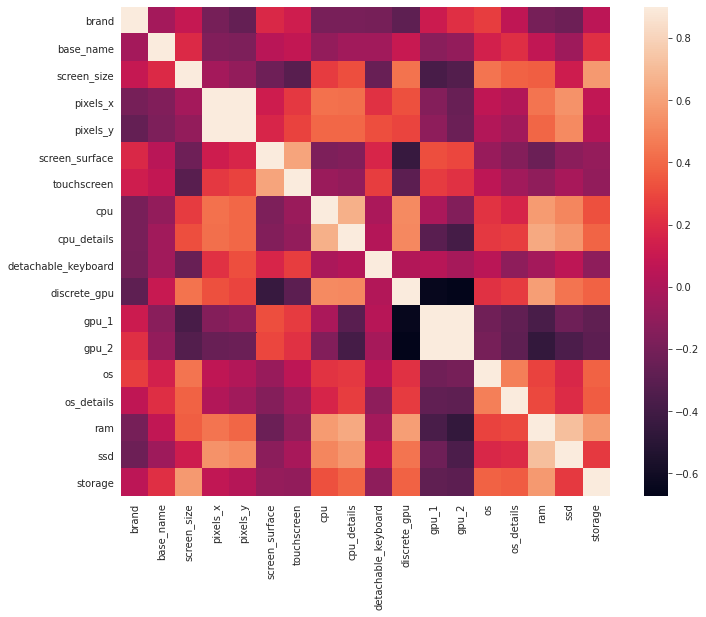

In [ ]:
corrmat = train_input2.iloc[:,0:18].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True) # note that only the original features are kept in this correlation plot

##2. Model fitting and evaluation

In order to select the best model, train_input3 is splitted into training and validation set. The splitting ratio is 80/20 for training/validation.

In [ ]:
# # Input Mehment's data
# train_input2 = pd.read_csv("trainFinal.csv", header = None)
# train_output = pd.read_csv("train_output.csv")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_input2, train_output,
                                                    test_size=.2,random_state=1)

In [ ]:
# Function to visualize the comparison between target and predicted values
def comparePred(test, pred):
  return(pd.DataFrame(np.array(test),
                      y_pred).reset_index().rename(columns={"index": "Prediction", 0: "Target"}).plot.kde())

### a. Catboost

In [ ]:
# # Model specification
# cb = CatBoostRegressor(iterations=189, objective = 'MAE', eval_metric = 'MAE',
#                           learning_rate=0.158, verbose = False,
#                           depth=3, l2_leaf_reg = 0.5)
# cb.fit(x_train, y_train['min_price'])

# # Getting output
# y_pred = cb.predict(x_test)
# mean_absolute_error(y_test['min_price'], y_pred) # Calculate MAE
# Model specification - for tuning hyperparameter 
cb = CatBoostRegressor(iterations=3000, objective = 'MultiRMSE', eval_metric = 'MultiRMSE',
                          learning_rate=0.12, verbose = False,
                          depth=8, l2_leaf_reg = 0.20226, early_stopping_rounds=20)
cb.fit(x_train, y_train)

# Getting output
y_pred = cb.predict(x_test)
y_pred = pd.DataFrame(y_pred, columns = ['min_price', 'max_price'])
a = mean_absolute_error(y_test['min_price'], y_pred['min_price'])
b = mean_absolute_error(y_test['max_price'], y_pred['max_price']) # Calculate MAE
print(b+a)

# cb_final = CatBoostRegressor(iterations=287, objective = 'MultiRMSE', eval_metric = 'MultiRMSE',
#                           learning_rate=0.12, verbose = False,
#                           depth=8, l2_leaf_reg = 0.202) # best so far

# cb = CatBoostRegressor(iterations=3000, objective = 'MultiRMSE', eval_metric = 'MultiRMSE',
#                           learning_rate=0.12, verbose = False,
#                           depth=8, l2_leaf_reg = 0.20223, early_stopping_rounds=20) # try submitting this

252.84288998943907


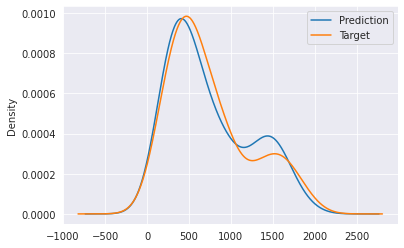

In [ ]:
comparePred(y_test['min_price'], y_pred)


### b. Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(x_train, y_train['min_price']);

# Getting output
y_pred = rf.predict(x_test)
mean_absolute_error(y_test['min_price'], y_pred)

142.75200344374414

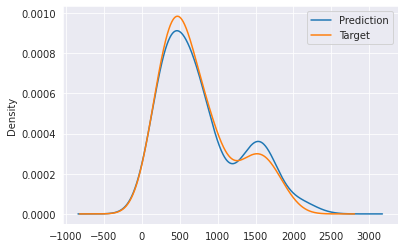

In [ ]:
comparePred(y_test['min_price'], y_pred)


### c. Neural Networks

In [ ]:
nn = MLPRegressor(hidden_layer_sizes = (10,),
                  activation= 'identity', solver = 'lbfgs', alpha = 0.0001, max_iter = 1000,
                  verbose = False)
nn.fit(x_train, y_train['min_price'])

# Getting output
y_pred = nn.predict(x_test)
mean_absolute_error(y_test['min_price'], y_pred) # Calculate MAE

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


151.25742947964048

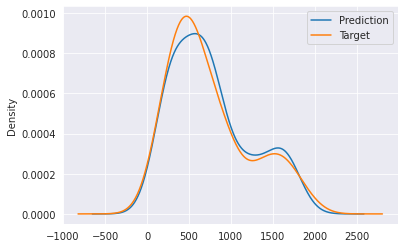

In [ ]:
comparePred(y_test['min_price'], y_pred)

Note that sklearn gives us an error of Convergence Warning regardless of number of iterations. This indicates that our data might not be suitable for this Multi-layer perceptron model.

### d. Elastic Net

In [ ]:
en = ElasticNet(alpha = 0.005, l1_ratio = 0.6, normalize = True, random_state = 712)
en.fit(x_train, y_train['min_price'])

# Getting output
y_pred = en.predict(x_test)
mean_absolute_error(y_test['min_price'], y_pred) # Calculate MAE

143.45765145613942

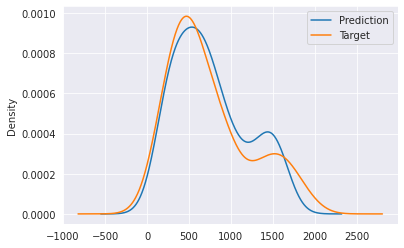

In [ ]:
comparePred(y_test['min_price'], y_pred)

### e. XGBoost

In [ ]:
xgb = XGBRegressor(max_depth = 2, learning_rate = 0.03, nrounds = 90, objective = "reg:squarederror",
                  early_stopping_rounds = 3, eval_metric = "mae")
xgb.fit(x_train, y_train['min_price'])

# Getting output
y_pred = xgb.predict(x_test)
mean_absolute_error(y_test['min_price'], y_pred) # Calculate MAE

127.3648315489526

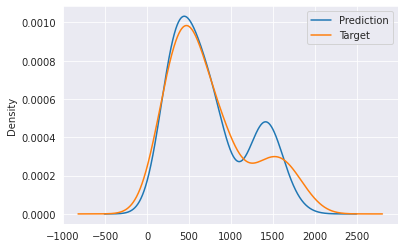

In [ ]:
comparePred(y_test['min_price'], y_pred)

Overall, Catboost seems to give the best result among the tested model. Two ways to improve the performance of these is to use Stacked generalization or perform GridSearch on the catboost model.
## 3. Model improvement
### 1. Stacked generalization

In [ ]:
# Create Base Learners
base_learners = [
                 ('cb', CatBoostRegressor(iterations=800, objective = 'MultiRMSE', eval_metric = 'MultiRMSE',
                          learning_rate=0.12,
                          depth=8, l2_leaf_reg = 0.20223)),
                 ('rf', RandomForestRegressor(n_estimators = 1000, random_state = 42)),
                 #('nn', MLPRegressor(hidden_layer_sizes = (10,),
                 # activation= 'identity', solver = 'lbfgs', alpha = 0.0001, max_iter = 1000
                 #  Does not converge - not included here))
                 ('xgb', XGBRegressor(max_depth = 2, learning_rate = 0.03, nrounds = 90, objective = "reg:squarederror",
                  early_stopping_rounds = 3, eval_metric = "mae"))           
                ]

# Initialize Stacking Regressor with the Meta Learner
reg = StackingRegressor(estimators=base_learners,
                         final_estimator=ElasticNet(alpha = 0.005, l1_ratio = 0.6,
                                                    normalize = True, random_state = 712), cv = 5)

In [ ]:
base_learners = [
                 ('cb', CatBoostRegressor(iterations=800, objective = 'MultiRMSE', eval_metric = 'MultiRMSE',
                          learning_rate=0.12,
                          depth=8, l2_leaf_reg = 0.20223)),
                 ('rf', RandomForestRegressor(n_estimators = 200, random_state = 42)),
                 ('xgb', XGBRegressor(max_depth = 6, nrounds = 200, objective = "reg:squarederror",
                  early_stopping_rounds = 3, eval_metric = "mae")),
                 ('knn', KNeighborsRegressor()),
                 ('lr', LinearRegression())           
                ]
reg = MultiOutputRegressor(StackingRegressor(cv = 10, estimators = base_learners, final_estimator = ElasticNet(alpha = 0.005, l1_ratio = 0.6,
                                                     normalize = True, random_state = 712)))

# reg = MultiOutputRegressor(StackingRegressor(estimators = base_learners, final_estimator = LinearRegression()))

In [ ]:
# reg.fit(x_train, y_train['min_price'])
reg.fit(x_train, y_train)

In [ ]:
# Testing only
reg.estimator.final_estimator_ = reg.estimator.final_estimator
y_pred = reg.predict(x_test)
y_pred = pd.DataFrame(y_pred, columns = ['min_price', 'max_price'])
a = mean_absolute_error(y_test['min_price'], y_pred['min_price'])
b = mean_absolute_error(y_test['max_price'], y_pred['max_price']) # Calculate MAE
print("Overall, the stacked model gives a SUMMED MAE result of " + str(a+b) + " on validation set")

Overall, the stacked model gives a SUMMED MAE result of 284.1913648565501 on validation set


In [ ]:
prediction = reg.predict(test_input2)
prediction = pd.DataFrame(prediction, columns = ['min_price', 'max_price'])
prediction.to_csv('/prediction.csv',index=False)

In [ ]:
comparePred(y_test['min_price'], y_pred.iloc[:,0]) # only works with one-dimensional data

The validation results is a bit disssapointing compared to XGBoost's and Catboost's results. It is known that stacking does not always improve the performance of the existing models. This is particularly relevant in this case, given that we already have several ensembled models. 

### 2. Cross-validation grid search on Catboost for hyperparameter tuning

In [ ]:
train_output_mean = np.average([train_output['min_price'], train_output['max_price']], axis = 0, weights = [0.5, 0.5])

Because two outputs of the training dataset has correlation $p = 0.99$, it might be sensible to average them and tune the catboost model based on this averaged result. 

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
model = CatBoostRegressor()
grid_search_result = model.grid_search(grid, 
                                       X=train_input2, 
                                       y=train_output_mean, 
                                       plot=True)
# No idea why this doesn't work - will check later

In [ ]:
cb_final = CatBoostRegressor(iterations=189, objective = 'MAE', eval_metric = 'MAE',
                          learning_rate=0.158, verbose = False,
                          depth=3, l2_leaf_reg = 0.5)

cb_final.fit(train_input2, train_output_mean)

# Getting output
prediction2 = cb_final.predict(test_input2)

In [ ]:
prediction2 = pd.DataFrame(prediction2)
drive.mount('/drive')
prediction2.to_csv('/drive/My Drive/KUL/prediction2.csv',index=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Unfortunately, the results are not desirable. As another approach, we actually want to fit a **multivariate** model which can take into account the correlation structure of our two-dimensional output:

In [ ]:
cb_final = CatBoostRegressor(iterations=3000, objective = 'MultiRMSE', eval_metric = 'MultiRMSE',
                           learning_rate=0.12, verbose = False,
                           depth=8, l2_leaf_reg = 0.20223, early_stopping_rounds=20) # best of the best
cb_final.fit(train_input2, train_output)

# Getting output
prediction3 = cb_final.predict(test_input2)
prediction3 = pd.DataFrame(prediction3, columns = ['min_price', 'max_price'])

In [ ]:
# Print output to Drive for submission
prediction3.to_csv('/prediction2.csv',index=False)

In [ ]:
prediction3.head()

min_price    max_price
0  1026.154730  1122.189792
1   378.498505   387.661723
2   813.121357   866.801137
3   535.447075   553.229898
4  1662.194291  1731.550934

## 4. Feature importance

In [ ]:
#!pip install shap
import shap

In [ ]:
explainer = shap.TreeExplainer(cb_final)
shap_values = explainer.shap_values(train_input2)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], train_input2.iloc[0,:])

# explainer = shap.TreeExplainer(cb)
# shap_values = explainer.shap_values(x_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


To assess the importance of each feature on the output of the model, we extract one particular prediction from a single laptop, as indicated by the figure above. Looking at this instance, one can see that the magnitude of the bar represents the strength of importance, while color indicates the direction of price's prediction. For example, CPU feature plays the most important role in predicting a laptop's market value. In addition, its red color signifies that this CPU feature pushes the laptop's prices higher. 

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], train_input2)

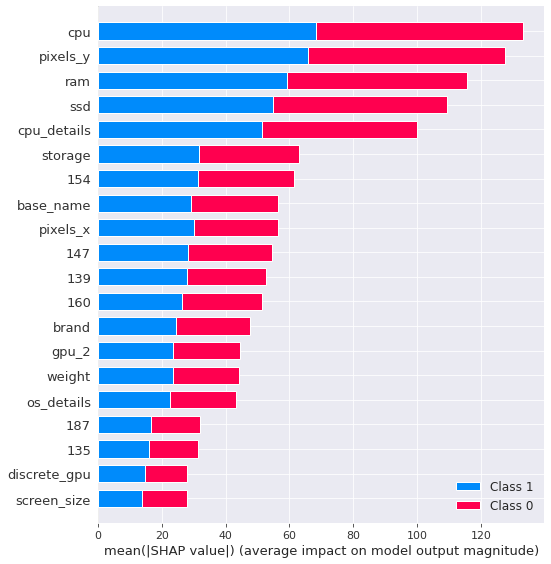

In [ ]:
# shap.summary_plot(shap_values, train_input2, plot_type="bar")


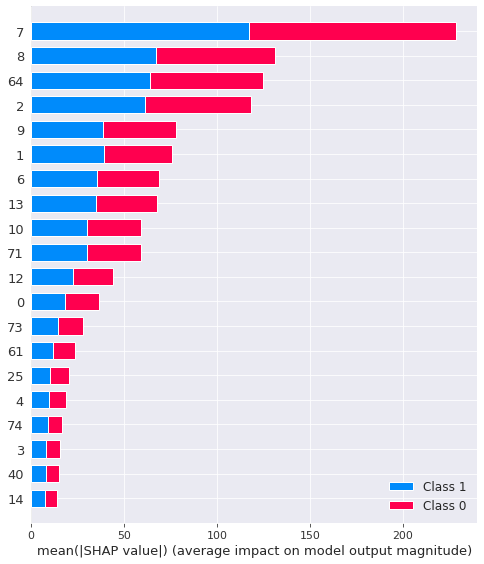

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")